## ANÁLISE DE RISCO DE EMPRÉSTIMO

### Projeto Final de Big Data - Modelo de Machine Learning

##### Integrantes:
Adriano Rossete, João Machado, Juliana Suzuki, Leandro Gimenez e Oscar Babilonia

In [2]:
# Import our libraries we are going to use for our data analysis.
import pandas as pd
import seaborn as sns
import numpy as np
import time
import functools
from pyspark.sql.functions import udf
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col, date_format
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import StringType
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as f

#Visualization Libraries
import matplotlib.pyplot as plt
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

#ML Libraries
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import OneHotEncoderEstimator

In [3]:
# File location and type
file_location = "/FileStore/tables/loan.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .option('escape','"') \
  .load(file_location)

#original_df = df

In [4]:
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]

def loan_condition(status):
    if status in bad_loan:
        return 1.0
    else:
        return 0.0
      
loan_cond_udf = udf(loan_condition, DoubleType())
df = df.withColumn('loan_condition',loan_cond_udf("loan_status"))

In [5]:
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
      
region_list_udf = udf(lambda x: finding_regions(x), StringType())
df = df.withColumn('region', region_list_udf('addr_state'))


In [6]:
df.select('term').distinct().show()

+----------+
 term|
+----------+
 36 months|
 60 months|
+----------+

In [7]:
#renaming the label column
df = df.withColumn("binary_response", f.col("loan_condition"))

In [8]:
display(df)

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,loan_condition,region,binary_response
1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,null,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,null,null,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.07141425,5831.78,5000.0,861.07,0.0,0.0,0.0,Jan-2015,171.62,null,Jan-2016,0.0,null,1.0,INDIVIDUAL,null,null,null,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,SouthWest,0.0
1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up. Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces,car,bike,309xx,GA,1.0,0.0,Apr-1999,5.0,null,null,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.71,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,null,Sep-2013,0.0,null,1.0,INDIVIDUAL,null,null,null,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,SouthEast,1.0
1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,null,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,null,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,null,null,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.65364445,3003.65,2400.0,603.65,0.0,0.0,0.0,Jun-2014,649.91,null,Jan-2016,0.0,null,1.0,INDIVIDUAL,null,null,null,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,MidWest,0.0
1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.",other,personel,917xx,CA,20.0,0.0,Feb-1996,1.0,35.0,null,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.3022123,12226.3,10000.0,2209.33,16.97,0.0,0.0,Jan-2015,357.48,null,Jan-2015,0.0,null,1.0,INDIVIDUAL,null,null,null,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,West,0.0
1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,REN

In [9]:
df.printSchema()

root
-- id: integer (nullable = true)
-- member_id: integer (nullable = true)
-- loan_amnt: double (nullable = true)
-- funded_amnt: double (nullable = true)
-- funded_amnt_inv: double (nullable = true)
-- term: string (nullable = true)
-- int_rate: double (nullable = true)
-- installment: double (nullable = true)
-- grade: string (nullable = true)
-- sub_grade: string (nullable = true)
-- emp_title: string (nullable = true)
-- emp_length: string (nullable = true)
-- home_ownership: string (nullable = true)
-- annual_inc: double (nullable = true)
-- verification_status: string (nullable = true)
-- issue_d: string (nullable = true)
-- loan_status: string (nullable = true)
-- pymnt_plan: string (nullable = true)
-- url: string (nullable = true)
-- desc: string (nullable = true)
-- purpose: string (nullable = true)
-- title: string (nullable = true)
-- zip_code: string (nullable = true)
-- addr_state: string (nullable = true)
-- dti: double (nullable = true)
-- delinq_2yrs: double (nullable = true)
-- earliest_cr_line: string (nullable = true)
-- inq_last_6mths: double (nullable = true)
-- mths_since_last_delinq: double (nullable = true)
-- mths_since_last_record: double (nullable = true)
-- open_acc: double (nullable = true)
-- pub_rec: double (nullable = true)
-- revol_bal: double (nullable = true)
-- revol_util: double (nullable = true)
-- total_acc: double (nullable = true)
-- initial_list_status: string (nullable = true)
-- out_prncp: double (nullable = true)
-- out_prncp_inv: double (nullable = true)
-- total_pymnt: double (nullable = true)
-- total_pymnt_inv: double (nullable = true)
-- total_rec_prncp: double (nullable = true)
-- total_rec_int: double (nullable = true)
-- total_rec_late_fee: double (nullable = true)
-- recoveries: double (nullable = true)
-- collection_recovery_fee: double (nullable = true)
-- last_pymnt_d: string (nullable = true)
-- last_pymnt_amnt: double (nullable = true)
-- next_pymnt_d: string (nullable = true)
-- last_credit_pull_d: string (nullable = true)
-- collections_12_mths_ex_med: double (nullable = true)
-- mths_since_last_major_derog: double (nullable = true)
-- policy_code: double (nullable = true)
-- application_type: string (nullable = true)
-- annual_inc_joint: double (nullable = true)
-- dti_joint: double (nullable = true)
-- verification_status_joint: string (nullable = true)
-- acc_now_delinq: double (nullable = true)
-- tot_coll_amt: double (nullable = true)
-- tot_cur_bal: double (nullable = true)
-- open_acc_6m: double (nullable = true)
-- open_il_6m: double (nullable = true)
-- open_il_12m: double (nullable = true)
-- open_il_24m: double (nullable = true)
-- mths_since_rcnt_il: double (nullable = true)
-- total_bal_il: double (nullable = true)
-- il_util: double (nullable = true)
-- open_rv_12m: double (nullable = true)
-- open_rv_24m: double (nullable = true)
-- max_bal_bc: double (nullable = true)
-- all_util: double (nullable = true)
-- total_rev_hi_lim: double (nullable = true)
-- inq_fi: double (nullable = true)
-- total_cu_tl: double (nullable = true)
-- inq_last_12m: double (nullable = true)
-- loan_condition: double (nullable = true)
-- region: string (nullable = true)
-- binary_response: double (nullable = true)

In [10]:
#checking null columns
display(df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]))

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,loan_condition,region,binary_response
0,0,0,0,0,0,0,0,0,0,51457,0,0,4,0,0,0,0,0,761350,0,151,0,0,0,29,29,29,454312,750326,29,29,0,502,29,0,0,0,0,0,0,0,0,0,0,17659,0,252971,53,145,665676,0,0,886868,886870,886868,29,70276,70276,866007,866007,866007,866007,866569,866007,868762,866007,866007,866007,866007,70276,866007,866007,866007,0,0,0


In [11]:
categoricalColumns = ['term', 'grade','home_ownership', 'verification_status', 'pymnt_plan', 'addr_state']

stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'binary_response', outputCol = 'label')
stages += [label_stringIdx]    

In [12]:
numericCols = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'installment',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'annual_inc',
       'int_rate']

In [13]:
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [14]:
modelCols = categoricalColumns+numericCols+['binary_response']

In [15]:
df_model = df.select(modelCols)
cols = df_model.columns
df_model = df_model.fillna(0, subset=numericCols)

In [16]:
df_model.printSchema()

root
-- term: string (nullable = true)
-- grade: string (nullable = true)
-- home_ownership: string (nullable = true)
-- verification_status: string (nullable = true)
-- pymnt_plan: string (nullable = true)
-- addr_state: string (nullable = true)
-- dti: double (nullable = false)
-- delinq_2yrs: double (nullable = false)
-- inq_last_6mths: double (nullable = false)
-- installment: double (nullable = false)
-- mths_since_last_delinq: double (nullable = false)
-- mths_since_last_record: double (nullable = false)
-- open_acc: double (nullable = false)
-- pub_rec: double (nullable = false)
-- revol_bal: double (nullable = false)
-- revol_util: double (nullable = false)
-- total_acc: double (nullable = false)
-- annual_inc: double (nullable = false)
-- int_rate: double (nullable = false)
-- binary_response: double (nullable = true)

In [17]:
display(df_model)

term,grade,home_ownership,verification_status,pymnt_plan,addr_state,dti,delinq_2yrs,inq_last_6mths,installment,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,annual_inc,int_rate,binary_response
36 months,B,RENT,Verified,n,AZ,27.65,0.0,1.0,162.87,0.0,0.0,3.0,0.0,13648.0,83.7,9.0,24000.0,10.65,0.0
60 months,C,RENT,Source Verified,n,GA,1.0,0.0,5.0,59.83,0.0,0.0,3.0,0.0,1687.0,9.4,4.0,30000.0,15.27,1.0
36 months,C,RENT,Not Verified,n,IL,8.72,0.0,2.0,84.33,0.0,0.0,2.0,0.0,2956.0,98.5,10.0,12252.0,15.96,0.0
36 months,C,RENT,Source Verified,n,CA,20.0,0.0,1.0,339.31,35.0,0.0,10.0,0.0,5598.0,21.0,37.0,49200.0,13.49,0.0
60 months,B,RENT,Source Verified,n,OR,17.94,0.0,0.0,67.79,38.0,0.0,15.0,0.0,27783.0,53.9,38.0,80000.0,12.69,0.0
36 months,A,RENT,Source Verified,n,AZ,11.2,0.0,3.0,156.46,0.0,0.0,9.0,0.0,7963.0,28.3,12.0,36000.0,7.9,0.0
60 months,C,RENT,Not Verified,n,NC,23.51,0.0,1.0,170.08,0.0,0.0,7.0,0.0,17726.0,85.6,11.0,47004.0,15.96,0.0
36 months,E,RENT,Source Verified,n,CA,5.35,0.0,2.0,109.43,0.0,0.0,4.0,0.0,8221.0,87.5,4.0,48000.0,18.64,0.0
60 months,F,OWN,Source Verified,n,CA,5.55,0.0,2.0,152.39,0.0,0.0,11.0,0.0,5210.0,32.6,13.0,40000.0,21.28,1.0
60 months,B,RENT,Verified,n,TX,18.08,0.0,0.0,121.45,0.0,0.0,2.0,0.0,9279.0,36.5,3.0,15000.0,12.69,1.0


In [18]:
display(df_model.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_model.columns]))

term,grade,home_ownership,verification_status,pymnt_plan,addr_state,dti,delinq_2yrs,inq_last_6mths,installment,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,annual_inc,int_rate,binary_response
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
for col in categoricalColumns:
    print(col, df_model.select(col).distinct().count())

('term', 2)
('grade', 7)
('home_ownership', 6)
('verification_status', 3)
('pymnt_plan', 2)
('addr_state', 51)

In [20]:

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_model)
df_model = pipelineModel.transform(df_model)
selectedCols = ['label', 'features'] + cols
df_model = df_model.select(selectedCols)
df_model.printSchema()

root
-- label: double (nullable = false)
-- features: vector (nullable = true)
-- term: string (nullable = true)
-- grade: string (nullable = true)
-- home_ownership: string (nullable = true)
-- verification_status: string (nullable = true)
-- pymnt_plan: string (nullable = true)
-- addr_state: string (nullable = true)
-- dti: double (nullable = false)
-- delinq_2yrs: double (nullable = false)
-- inq_last_6mths: double (nullable = false)
-- installment: double (nullable = false)
-- mths_since_last_delinq: double (nullable = false)
-- mths_since_last_record: double (nullable = false)
-- open_acc: double (nullable = false)
-- pub_rec: double (nullable = false)
-- revol_bal: double (nullable = false)
-- revol_util: double (nullable = false)
-- total_acc: double (nullable = false)
-- annual_inc: double (nullable = false)
-- int_rate: double (nullable = false)
-- binary_response: double (nullable = true)

In [21]:
df_model.groupBy('binary_response').count().show()

+---------------+------+
binary_response| count|
+---------------+------+
 0.0|819950|
 1.0| 67429|
+---------------+------+

In [22]:
df_model_sample = df_model.sampleBy('binary_response', fractions={1.0: 1, 0.0: 0.1}, seed=100) #seed =100 Good Loan = 0.3 75% DE ACURACIA

In [23]:
df_model_sample.groupBy('binary_response').count().show()

+---------------+-----+
binary_response|count|
+---------------+-----+
 0.0|81405|
 1.0|67429|
+---------------+-----+

In [24]:
train, test = df_model_sample.randomSplit([0.7, 0.3], seed = 100)

In [25]:
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 104453
Test Dataset Count: 44381

## REGRESSÃO LOGÍSTICA

In [27]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

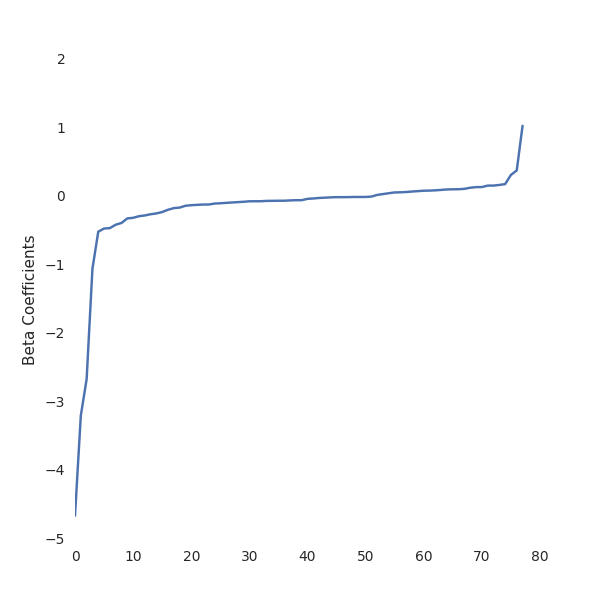

In [28]:
beta = np.sort(lrModel.coefficients)
fig = plt.figure(figsize=(6,6))
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()
display(fig)

In [29]:
predictionsLR = lrModel.transform(test)
predictionsLR.select('grade', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+-----+--------------------+----------+--------------------+
grade|label| rawPrediction|prediction| probability|
+-----+-----+--------------------+----------+--------------------+
 B| 0.0|[0.58978409247469...| 0.0|[0.64331560494915...|
 B| 0.0|[0.28833999590307...| 0.0|[0.57158968796168...|
 B| 0.0|[0.75273297423531...| 0.0|[0.67977390874024...|
 B| 0.0|[0.53739582387679...| 0.0|[0.63120641232182...|
 B| 0.0|[0.96022996355259...| 0.0|[0.72316784529631...|
 B| 0.0|[0.66076204408189...| 0.0|[0.65943155030274...|
 B| 0.0|[0.45934356249013...| 0.0|[0.61285843936765...|
 B| 0.0|[0.38424072066034...| 0.0|[0.59489550465285...|
 B| 0.0|[0.80952360835663...| 0.0|[0.69200797884067...|
 B| 0.0|[0.77291480665753...| 0.0|[0.68415108739584...|
+-----+-----+--------------------+----------+--------------------+
only showing top 10 rows

In [30]:
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction"
)


accuracy_lr = evaluator_accuracy.evaluate(predictionsLR)
print('accuracy:         {:.4f}'.format(accuracy_lr))
auc_lr = evaluator_auc.evaluate(predictionsLR)
print('areaUnderROC:     {:.4f}'.format(auc_lr))

#accuracy:         0.7193
#areaUnderROC:     0.6963
#fractions={1.0: 1, 0.0: 0.1}, seed=100)

accuracy: 0.6476
areaUnderROC: 0.7040

In [31]:
predictionsLR.select('label', 'prediction').createOrReplaceTempView('predictionsLR')

spark.sql("""
SELECT
    round((tp+tn)/(tp+tn+fp+fn), 4) as accuracy,
    round(tp/(tp+fp), 4) as precision,
    round(tp/(tp+fn), 4) as recall
FROM (
    SELECT
        sum(tn) as tn,
        sum(tp) as tp,
        sum(fn) as fn,
        sum(fp) as fp
    FROM (
        SELECT
            case when label = 0.0 and prediction = 0.0 then 1 else 0 end as tn,
            case when label = 1.0 and prediction = 1.0 then 1 else 0 end as tp,
            case when label = 1.0 and prediction = 0.0 then 1 else 0 end as fn,
            case when label = 0.0 and prediction = 1.0 then 1 else 0 end as fp
        FROM
            predictionsLR
    )
)
""").show()

+--------+---------+------+
accuracy|precision|recall|
+--------+---------+------+
 0.6476| 0.6254|0.5565|
+--------+---------+------+

In [32]:
predictionsLR.select('label', 'prediction').createOrReplaceTempView('predictionsLR')

spark.sql("""
    SELECT
        sum(tn) as tn,
        sum(tp) as tp,
        sum(fn) as fn,
        sum(fp) as fp
    FROM (
        SELECT
            case when label = 0.0 and prediction = 0.0 then 1 else 0 end as tn,
            case when label = 1.0 and prediction = 1.0 then 1 else 0 end as tp,
            case when label = 1.0 and prediction = 0.0 then 1 else 0 end as fn,
            case when label = 0.0 and prediction = 1.0 then 1 else 0 end as fp
        FROM
            predictionsLR
    )

""").show()

+-----+-----+----+----+
 tn| tp| fn| fp|
+-----+-----+----+----+
17533|11206|8929|6713|
+-----+-----+----+----+

## RANDOM FOREST

In [34]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictionsRF = rfModel.transform(test)
predictionsRF.select('grade', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+-----+--------------------+----------+--------------------+
grade|label| rawPrediction|prediction| probability|
+-----+-----+--------------------+----------+--------------------+
 B| 0.0|[12.5962715444486...| 0.0|[0.62981357722243...|
 B| 0.0|[11.0244244025900...| 0.0|[0.55122122012950...|
 B| 0.0|[13.3178300453984...| 0.0|[0.66589150226992...|
 B| 0.0|[12.4251174744558...| 0.0|[0.62125587372279...|
 B| 0.0|[13.4176888363498...| 0.0|[0.67088444181749...|
 B| 0.0|[13.4181741798338...| 0.0|[0.67090870899169...|
 B| 0.0|[12.7371354103899...| 0.0|[0.63685677051949...|
 B| 0.0|[12.5676006298981...| 0.0|[0.62838003149490...|
 B| 0.0|[13.6956080804080...| 0.0|[0.68478040402040...|
 B| 0.0|[13.1210149320590...| 0.0|[0.65605074660295...|
+-----+-----+--------------------+----------+--------------------+
only showing top 10 rows

In [35]:
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction"
)


accuracy_rf = evaluator_accuracy.evaluate(predictionsRF)
print('accuracy:         {:.4f}'.format(accuracy_rf))
auc_rf = evaluator_auc.evaluate(predictionsRF)
print('areaUnderROC:     {:.4f}'.format(auc_rf))



accuracy: 0.6422
areaUnderROC: 0.6961

In [36]:
predictionsRF.select('label', 'prediction').createOrReplaceTempView('predictionsRF')

spark.sql("""
SELECT
    round((tp+tn)/(tp+tn+fp+fn), 4) as accuracy,
    round(tp/(tp+fp), 4) as precision,
    round(tp/(tp+fn), 4) as recall
FROM (
    SELECT
        sum(tn) as tn,
        sum(tp) as tp,
        sum(fn) as fn,
        sum(fp) as fp
    FROM (
        SELECT
            case when label = 0.0 and prediction = 0.0 then 1 else 0 end as tn,
            case when label = 1.0 and prediction = 1.0 then 1 else 0 end as tp,
            case when label = 1.0 and prediction = 0.0 then 1 else 0 end as fn,
            case when label = 0.0 and prediction = 1.0 then 1 else 0 end as fp
        FROM
            predictionsRF
    )
)
""").show()

+--------+---------+------+
accuracy|precision|recall|
+--------+---------+------+
 0.6422| 0.6101|0.5855|
+--------+---------+------+

In [37]:
predictionsRF.select('label', 'prediction').createOrReplaceTempView('predictionsRF')

spark.sql("""
    SELECT
        sum(tn) as tn,
        sum(tp) as tp,
        sum(fn) as fn,
        sum(fp) as fp
    FROM (
        SELECT
            case when label = 0.0 and prediction = 0.0 then 1 else 0 end as tn,
            case when label = 1.0 and prediction = 1.0 then 1 else 0 end as tp,
            case when label = 1.0 and prediction = 0.0 then 1 else 0 end as fn,
            case when label = 0.0 and prediction = 1.0 then 1 else 0 end as fp
        FROM
            predictionsRF
    )

""").show()

+-----+-----+----+----+
 tn| tp| fn| fp|
+-----+-----+----+----+
16710|11790|8345|7536|
+-----+-----+----+----+